# The Effect of Background Contrast on Perceived Transparency

The purpose of this notebook is to create and visualise an example of the stimuli that are created in the bachelor thesis.

In [497]:
import numpy as np
from numpy import asarray
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import contrast_metrics as cm
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt
from ipywidgets.widgets import FloatSlider
from matplotlib.colors import LogNorm

In [370]:
class TextureFactory(object):
    """
    A factory to generate a checkerboard background where the luminance value of each block 
    is uniformly drawn from the given luminance_values with variable transparency circles.
    
    Example Usage:

 >>> f_c = TextureFactory('checkerboard',10,image_width=200)
>>> img_c = f_c.get_image(.5, .25, bg_luminance=.5)
>>> f_r = TextureFactory('random',2,image_width=200)
>>> img_r = f_r.get_image(1, .5)

    Parameters
    ----------
    block_width : int
        Determines the "granularity" of the texture.
    luminance_values : tuple[float], optional
    image_width : int, optional
    """

    def __init__(self, mode, block_width, luminance_values=(0., 1.), image_width=480):
        self.image_width = image_width

        if mode == 'random':
            n_blocks = int(np.ceil(image_width / block_width))
            r = np.ndarray((n_blocks, n_blocks))
            for i in range(block_width):
                for j in range(block_width):
                    if (i % 5) == 0: r[i][j] = luminance_values[j % 5]
                    if (i % 5) == 1: r[i][j] = luminance_values[(j + 1) % 5]
                    if (i % 5) == 2: r[i][j] = luminance_values[(j + 2) % 5]
                    if (i % 5) == 3: r[i][j] = luminance_values[(j + 3) % 5]
                    if (i % 5) == 4: r[i][j] = luminance_values[(j + 4) % 5]

            t = np.repeat(np.repeat(r, block_width, axis=0), block_width, axis=1)
            self.texture = t[:image_width, :image_width]

        elif mode == 'checkerboard':
            self.texture = np.ndarray((image_width, image_width))
            for i, j in np.ndindex((image_width, image_width)):
                x = (i // block_width) % 2
                y = (j // block_width) % 2
                self.texture[i, j] = luminance_values[0] if x == y else luminance_values[4]
        else:
            raise ValueError("invalid mode")



    def get_image(self, tau, alpha, circle_radius=150, bg_luminance=None, stack_option='none'):
        """
        Adds the transparency circle and optionally a cutout background, and returns the image.
        Underlying texture remains unchanged for reuse.

        Parameters
        ----------
        tau, alpha: float
            alpha blending params of transparency circle.
        circle_radius : int, optional
        
        Returns
        -------
        np.ndarray
            Grayscale image as a square matrix with values between 0 and 1.
        """
        image = self.texture.copy()

        # compute distances from image center (=radius) of each pixel
        x = np.linspace(-0.5 * self.image_width, 0.5 * self.image_width, self.image_width)
        radii = np.sqrt((x ** 2)[np.newaxis] + (x ** 2)[:, np.newaxis])

        # add transparent circle
        idx = radii <= circle_radius
        image[idx] = alpha * image[idx] + (1 - alpha) * tau
        
        before_cutout = image.copy()

        # cut out center and fill in background
        if bg_luminance is not None:
            idx = radii > circle_radius
            image[idx] = bg_luminance

        if stack_option == 'none':
            return image
        elif stack_option == 'horizontal':
            return np.block([before_cutout, image])
        elif stack_option == 'vertical':
            return np.block([[before_cutout], [image]])
        elif stack_option == 'both':
            return np.block([[before_cutout, image], [image, before_cutout]])
        else:
            raise ValueError('Invalid value given for stack_option.')


In [371]:
    def shuffle(a, b, seed):
        """""
        Shuffles the luminance values in the array of luminances so that the checkerboard will be randomly ordered.
        
        Parameters
        ----------
        a, b: Any
            values in the array to shuffle
        seed: Any, optional
            Random seed used to initialize the pseudo-random number generator
        
        Example usage
        >>> shuffle(luminace_values2[0], luminace_values2[i + 1], 12345)
        """""
        rand_state = np.random.RandomState(seed)
        rand_state.shuffle(a)
        rand_state.seed(seed)
        rand_state.shuffle(b)

In [442]:
    def create_image():
        
        # compute texture with n-dimensional checkerboard pattern
        n = 21
        image_width = 480
        block_width = image_width // n

        tau_circle = 0.5
        alpha_circle = 0.5
        
        
        
        luminace_values2 = [0.000001, 0.25, 0.5, 0.75, 1.0],[0.2, 0.35, 0.5, 0.65, 0.8], [0.45,0.475,0.5,0.525,0.55] #[0.05, 0.275, 0.5, 0.725, 0.95] , [0.1, 0.3, 0.5, 0.7, 0.9], [0.15, 0.325, 0.5, 0.675, 0.85], [0.2, 0.35, 0.5, 0.65, 0.8], [0.25, 0.375, 0.5, 0.625, 0.75], \[0.3, 0.4, 0.5, 0.6, 0.7], [0.35, 0.425, 0.5, 0.575, 0.65], [0.4, 0.45, 0.5, 0.55, 0.6], [0.45,0.475,0.5,0.525,0.55]

        tau_values = 1.0   # 0.0, 0.2, 0.5, 1.0
        alpha_values = 0.2  # 0.1, 0.2, 0.5


        for i in range(len(luminace_values2) - 1):
            shuffle(luminace_values2[0], luminace_values2[i + 1], 12345)

        for luminance in luminace_values2:
        
            f2 = TextureFactory('random',block_width=block_width, image_width=image_width,luminance_values=luminance)


            # Creating stimuli with background contrast and transparent media with given alpha and tau
            filename = f"Images/{luminance}_contrast_,alpha_{alpha_values}_tau_{tau_values}.png"
            img1 = f2.get_image(tau_values, alpha_values, bg_luminance=None)
            plt.figure()
            plt.imshow(img1, cmap='gray', vmin=0, vmax=1)
            plt.axis('off')
            plt.savefig(filename, dpi=300, bbox_inches='tight')
            
        return tau_values, alpha_values, luminance, luminace_values2
        

(1.0,
 0.2,
 [0.45, 0.55, 0.525, 0.475, 0.5],
 ([1e-06, 0.5, 0.25, 1.0, 0.75],
  [0.2, 0.8, 0.65, 0.35, 0.5],
  [0.45, 0.55, 0.525, 0.475, 0.5]))

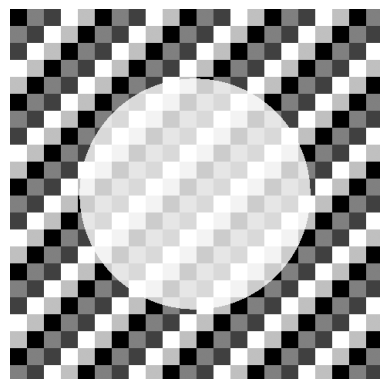

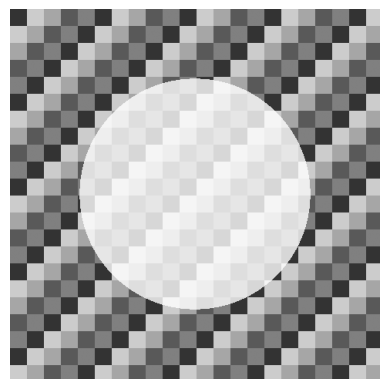

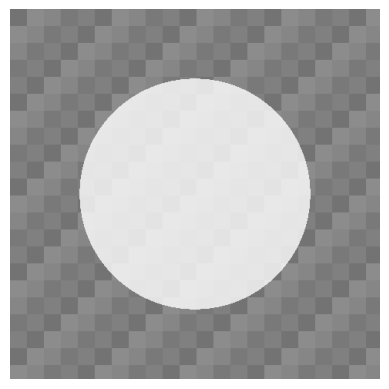

In [443]:
create_image()

### Here are three stimuli with equal alpha and tau, but with varying background contrasts are created
As the goal of the paper is to investigate the effect of the background contrast on the perceived transparency, I generated different backgrounds to a fixed transparent medium with a fixed transmittance and luminance. 
In order to achieve this, a transparent media with alpha and tau
values was created on the background with highest contrast 1.0, cut out
and pasted on variegated checkerboards with different background contrasts.


In [444]:
def create_mask(a):
        """""
        Creates a mask in size of the transparent medium of the stimuli
        
        Parameter
        ---------
        a: String
            a stimulus from which the mask will be created
            
        Example usage: 
        >>> create_mask("example.png")
        
        """""
        
        tau_values, alpha_values, luminance, luminace_values2 = create_image()
        a = f"Images/{luminace_values2[0]}_contrast_,alpha_{alpha_values}_tau_{tau_values}.png"
        im2 = Image.open(a)
        mask_im = Image.new("L", im2.size, 1)
        draw = ImageDraw.Draw(mask_im)
        draw.ellipse((239.5, 239.5, 928.5, 928.5), fill=255)
        #plt.imshow(mask_im)
        mask_im.save("Images/mask.png", quality=95)
        return mask_im

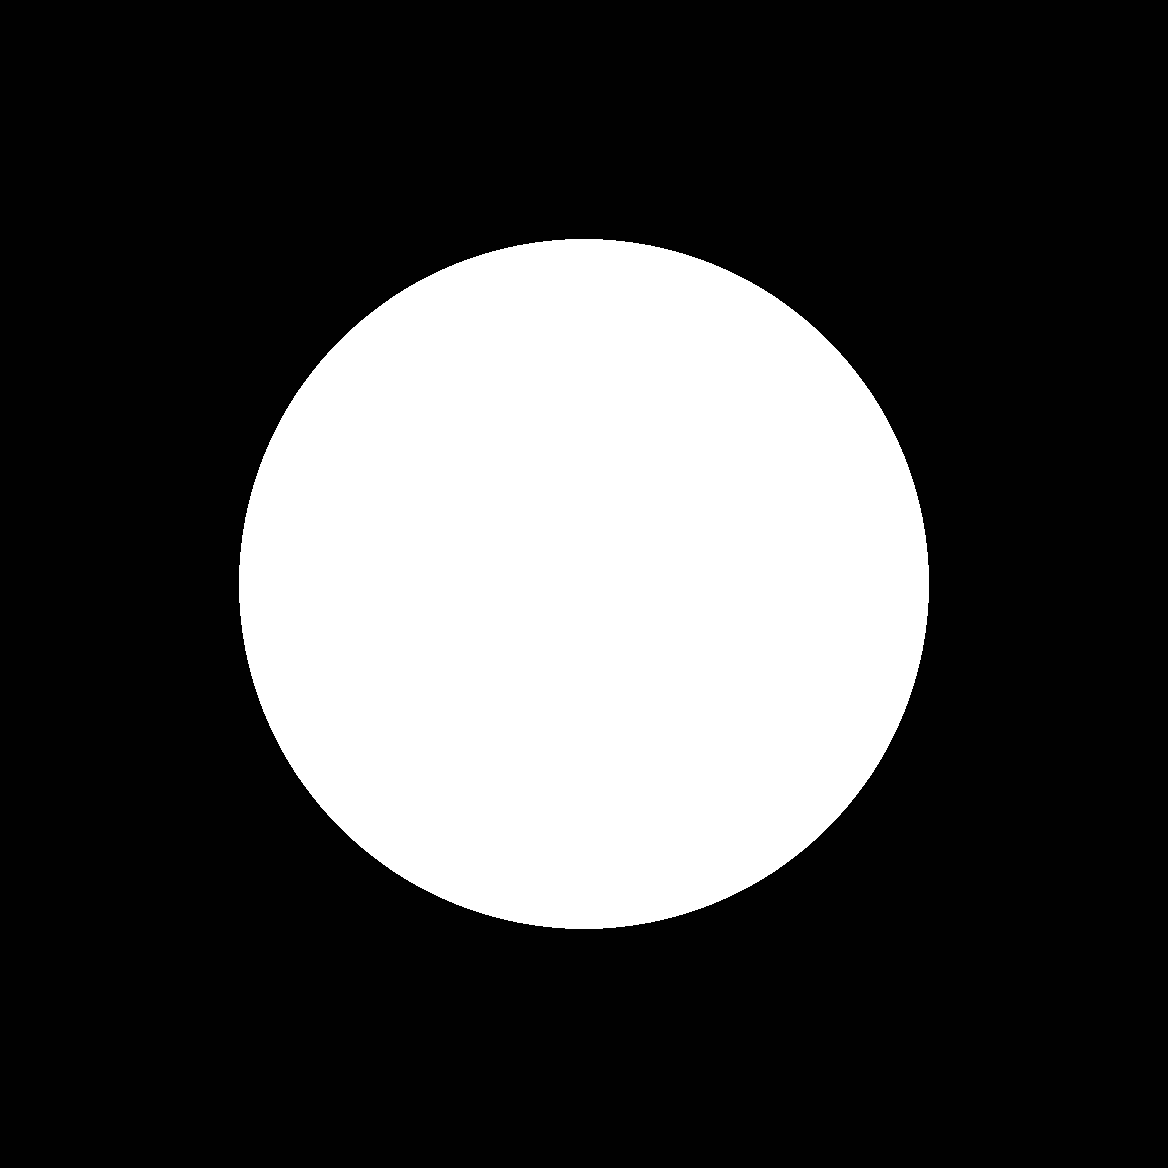

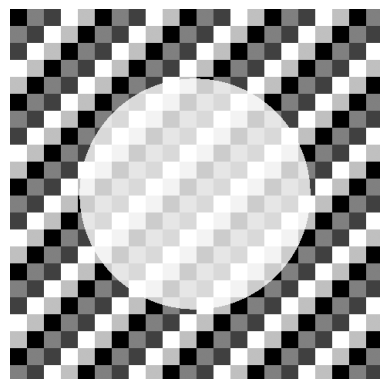

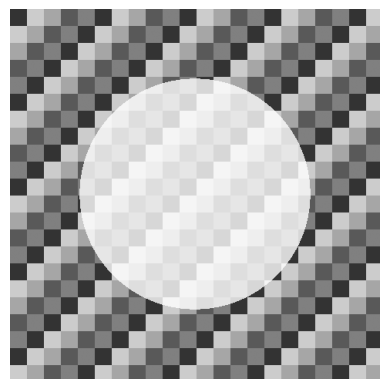

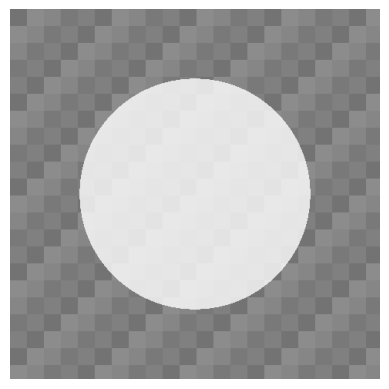

In [445]:
create_mask(f"Images/{luminace_values2[0]}_contrast_,alpha_{alpha_values}_tau_{tau_values}.png")

In [483]:
def add_circle(a, b):
    """""

     The transparent media with alpha and tau values on the background with highest contrast is cut out and pasted on variegated checkerboards with different background contrasts.

    Parameters
    ----------
    a, b: String
        The file name of the images. a is for the stimulus that the transparent medium will be pasted on, b is for the stimulus with the highest background contrast.
 
    
    Example usage
    >>> add_circle(f"Images/{luminance}_contrast_,alpha_{alpha}_tau_{tau}.png", f"Images/{luminace_values2[0]}_contrast_,alpha_{alpha}_tau_{tau}.png")
        
    """""
    # getting the needed values from create_image() function
    tau_values, alpha_values, luminance, luminace_values2 = create_image()
    #print(luminance)
    
    #a = f"Images/{luminance}_contrast_,alpha_{alpha_values}_tau_{tau_values}.png"
    b = f"Images/{luminace_values2[0]}_contrast_,alpha_{alpha_values}_tau_{tau_values}.png"
    #im1 = Image.open(a)
    im2 = Image.open(b)
    mask_im = create_mask(b)
    
    
    # copying and pasting the transparent medium of the stimulus with highest background on other backgrounds
    
    for luminance in luminace_values2:
        a = f"Images/{luminance}_contrast_,alpha_{alpha_values}_tau_{tau_values}.png"
        print(a)
        im1 = Image.open(a)
        plt.imshow(im1)
        back_im = im1.copy()
        back_im.paste(im2, (0, 0), mask_im)
        plt.imshow(back_im)
        final = back_im.paste(im2, (0, 0), mask_im)
        back_im.save(f"Images/Stimuli_{luminance}_a{alpha_values}_t{tau_values}.png", quality=95)
        

    return tau_values, alpha_values, luminance, luminace_values2
        

Images/[1e-06, 0.5, 0.25, 1.0, 0.75]_contrast_,alpha_0.2_tau_1.0.png
Images/[0.2, 0.8, 0.65, 0.35, 0.5]_contrast_,alpha_0.2_tau_1.0.png
Images/[0.45, 0.55, 0.525, 0.475, 0.5]_contrast_,alpha_0.2_tau_1.0.png


(1.0,
 0.2,
 [0.45, 0.55, 0.525, 0.475, 0.5],
 ([1e-06, 0.5, 0.25, 1.0, 0.75],
  [0.2, 0.8, 0.65, 0.35, 0.5],
  [0.45, 0.55, 0.525, 0.475, 0.5]))

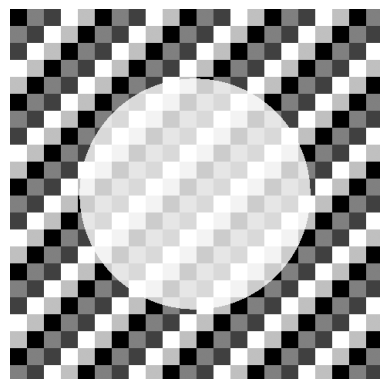

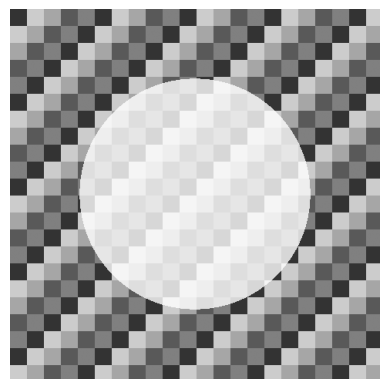

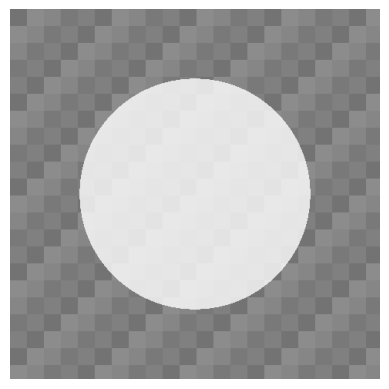

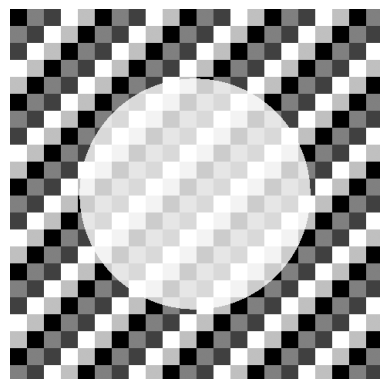

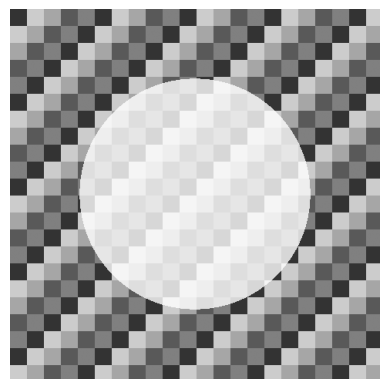

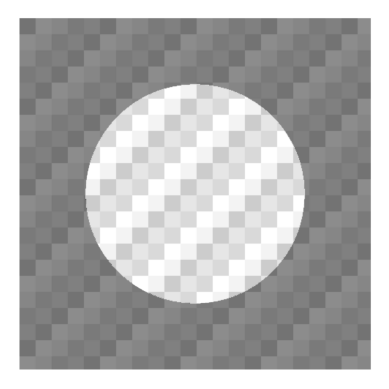

In [484]:
add_circle(f"{luminance}_contrast_,alpha_{alpha_values}_tau_{tau_values}.png", f"Images/{luminace_values2[0]}_contrast_,alpha_{alpha_values}_tau_{tau_values}.png")

# Now every stimuli have the same transparent medium but on varying backgrounds.
The next step is to calculate the contrast metrics of the transparent media and background contrast for every stimuli and to evaluate the metrics. There are three contrast metrics:
1) Michelson Contrast
$$
\frac{l_{min}-l_{max}}{l_{min}+l_{max}}
$$
with $l_{min}$ and $l_{max}$ being the minimum and maximum luminances.

2) SAM (Space-averaged Michelson contrast)

3) SAW (Space-averaged Whittle contrast)

In [485]:
def image_as_array():
    # Making the image and the mask arrays
    tau_values, alpha_values, luminance, luminace_values2 = add_circle("x", "y")
    
    # Convert the mask to numpy array
    im = Image.open("Images/mask.png").convert("L")
    ims_array = asarray(im)
    ims_array1 = ims_array.astype(np.double)
    
    for luminance in luminace_values2:
        print(luminance)
        a = f"Images/Stimuli_{luminance}_a{alpha_values}_t{tau_values}.png"
        image = Image.open(a).convert("L")
        # Convert the stimulus to numpy array
        data = asarray(image)
        data1 = data.astype(np.double)
        print(data)
        print(data1)
       
    
    return data, ims_array
    
    

Images/[1e-06, 0.5, 0.25, 1.0, 0.75]_contrast_,alpha_0.2_tau_1.0.png
Images/[0.2, 0.8, 0.65, 0.35, 0.5]_contrast_,alpha_0.2_tau_1.0.png
Images/[0.45, 0.55, 0.525, 0.475, 0.5]_contrast_,alpha_0.2_tau_1.0.png
[1e-06, 0.5, 0.25, 1.0, 0.75]
[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]
[[255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]
 ...
 [255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]]
[0.2, 0.8, 0.65, 0.35, 0.5]
[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]
[[255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]
 ...
 [255. 

(array([[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]], dtype=uint8),
 array([[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]], dtype=uint8))

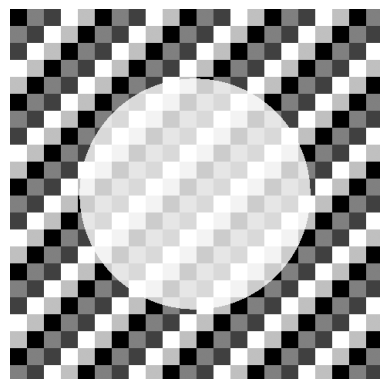

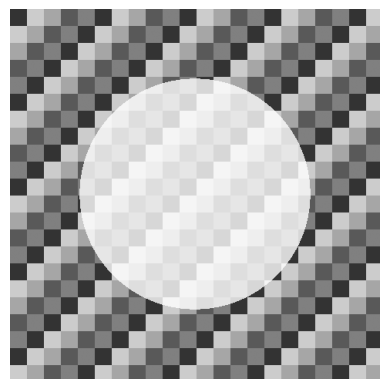

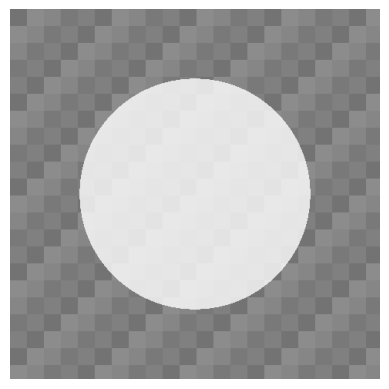

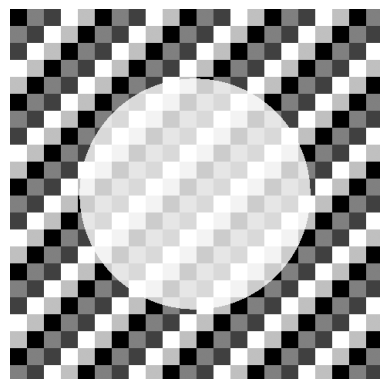

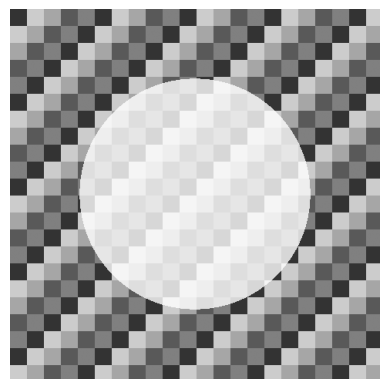

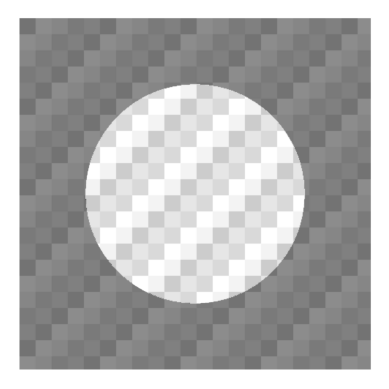

In [486]:
image_as_array()

### Calculate the contrast of the background and the transparent medium of each stimulus


Images/[1e-06, 0.5, 0.25, 1.0, 0.75]_contrast_,alpha_0.2_tau_1.0.png
Images/[0.2, 0.8, 0.65, 0.35, 0.5]_contrast_,alpha_0.2_tau_1.0.png
Images/[0.45, 0.55, 0.525, 0.475, 0.5]_contrast_,alpha_0.2_tau_1.0.png
[1e-06, 0.5, 0.25, 1.0, 0.75]
[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]
[[255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]
 ...
 [255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]]
[0.2, 0.8, 0.65, 0.35, 0.5]
[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]
[[255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]
 ...
 [255. 

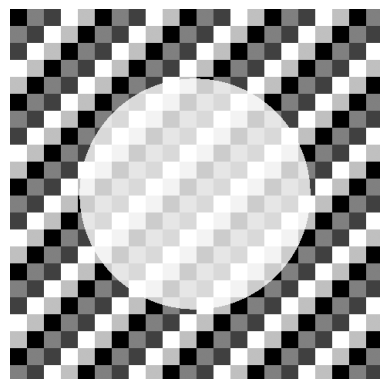

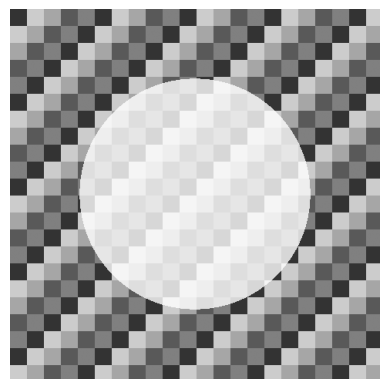

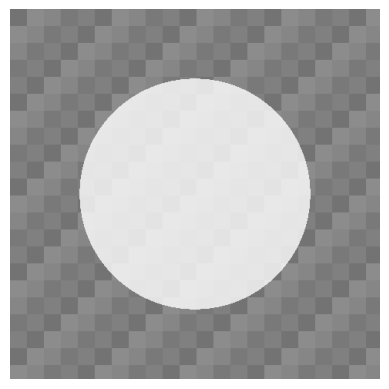

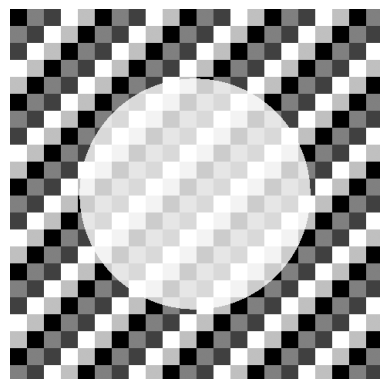

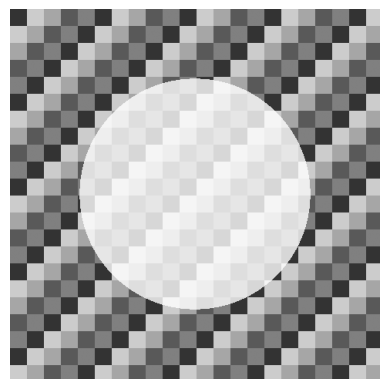

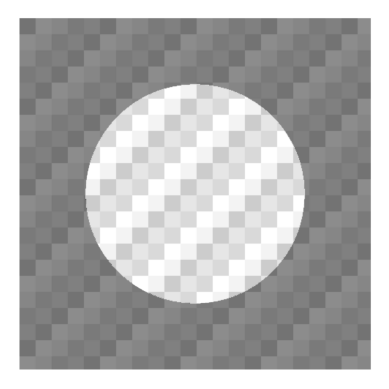

In [487]:
data, ims_array = image_as_array()
print("contrastSAM:", cm.SAM(data, mask=(ims_array == 1),mode="unique"))
print("contrastSAM:", cm.SAM(data, mask=(ims_array == 0), mode="unique"))
print("contrastSAW:", cm.SAW(data, mask=(ims_array == 1), mode="unique"))
print("contrastSAW:", cm.SAW(data, mask=(ims_array == 0), mode="unique"))
print("contrast MC:",cm.mc_single(data,data))

## Now you can use the interact tool to see how transmittance, luminance and background contrast affect the perception of the transparency of the medium.

In [528]:
def plot_stimuli(tau_values, alpha_values, luminance, luminace_values2):
    tau_values, alpha_values, luminance, luminace_values2 = add_circle("x", "y")
    a = f"Images/Stimuli_{luminance}_a{alpha_values}_t{tau_values}.png"
    for luminance in luminace_values2:
            # Background contrast
            plt.subplot(222)
            image = Image.open(a).convert("L")
            plt.imshow(image)
            plt.colorbar()
            plt.title('Background contrast')
            plt.xlabel('---')
            plt.ylabel('---')

            # Luminance
            plt.subplot(223)
            image = Image.open(a).convert("L")
            plt.imshow(image)
            plt.plot(tau_values, tau_values)
            plt.title('Luminance')
            plt.xlabel('--')
            plt.ylabel('---')
            plt.show()

            #Transmittance
            plt.subplot(224)
            image = Image.open(a).convert("L")
            plt.imshow(image)
            plt.plot(alpha_values, alpha_values)
            plt.title('Transmittance')
            plt.xlabel('---')
            plt.ylabel('---')
            plt.show()

In [529]:
# Interactively plot the grating to get to know the effect of different parameters:
def explore_stimuli(bgc, alpha, tau):
    
    # Plotting
    tau_values, alpha_values, luminance, luminace_values2 = add_circle("x", "y")
    plot_stimuli(tau_values, alpha_values, luminance, luminace_values2) 

Images/[1e-06, 0.5, 0.25, 1.0, 0.75]_contrast_,alpha_0.2_tau_1.0.png
Images/[0.2, 0.8, 0.65, 0.35, 0.5]_contrast_,alpha_0.2_tau_1.0.png
Images/[0.45, 0.55, 0.525, 0.475, 0.5]_contrast_,alpha_0.2_tau_1.0.png


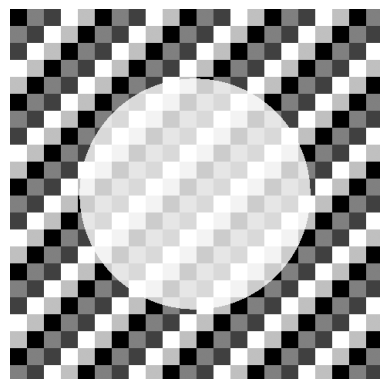

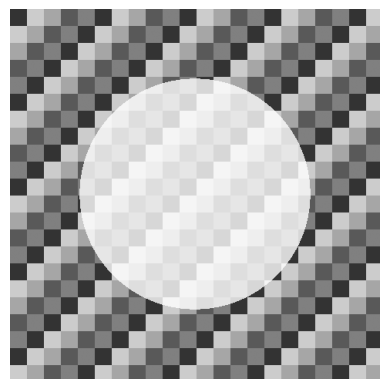

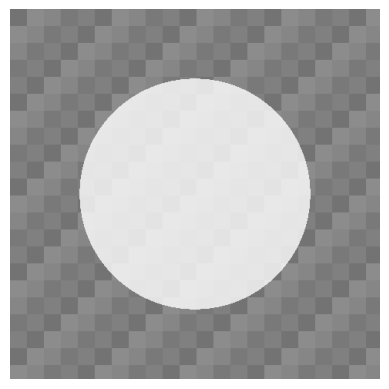

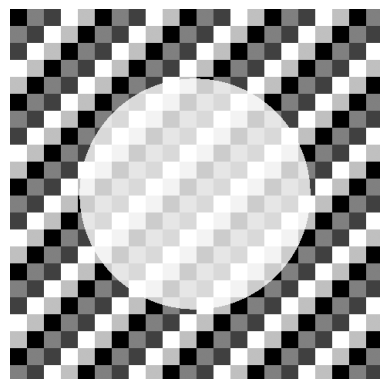

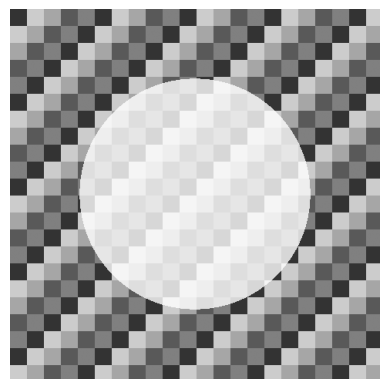

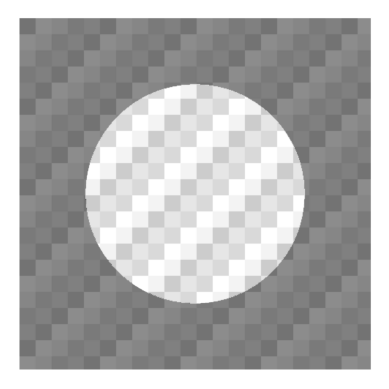

interactive(children=(FloatSlider(value=0.5, description='Background Contrast', max=1.0), FloatSlider(value=0.…

<function __main__.explore_stimuli(bgc, alpha, tau)>

In [530]:
tau_values, alpha_values, luminance, luminace_values2 = add_circle("x", "y")
interact(explore_stimuli, 
         bgc=FloatSlider(description='Background Contrast', min=0.0, max=1.0, step=0.1, value=0.5),
         alpha=FloatSlider(description='Transmittance of the Transparent Medium', min=0.0, max=1.0, step=0.1, value=0.5),
         tau=FloatSlider(description='Luminance of the Transparent Medium', min=0.0, max=1.0, step=0.1, value=0.5),
         )
